In [8]:
import sklearn
from pathlib import Path
import shutil

# %% Configurações de dataset
DATASET_NAME = 'wine'
RANDOM_STATE = 1

# %% Carregamento
# X, y = sklearn.datasets.fetch_openml(name=DATASET_NAME, version=1, return_X_y=True, as_frame=True)
X, y = sklearn.datasets.load_wine(return_X_y=True, as_frame=True)

# %% Split
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X, y, random_state=RANDOM_STATE, stratify=y
)

# %% Diretórios temporários
TMP_ROOT = Path('../results/tmp') / DATASET_NAME
if TMP_ROOT.exists():
    shutil.rmtree(TMP_ROOT)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((133, 13), (45, 13), (133,), (45,))

In [9]:
from tpot import TPOTClassifier
from tpot import objectives
import time

def run_tpot(early_stop=20, max_time_mins=float('inf'), warm_start=False, search_space="linear"):
    scorer = sklearn.metrics.get_scorer('f1_weighted')

    tpot = TPOTClassifier(
        search_space=search_space,
        scorers=[scorer, objectives.complexity_scorer],
        scorers_weights=[1.0, -1.0],
        cv = 10,
        memory= str(TMP_ROOT / 'memory'),
        preprocessing= True,
        max_time_mins=max_time_mins,
        n_jobs=1,
        validation_strategy='split',
        early_stop=early_stop,
        warm_start=warm_start,
        periodic_checkpoint_folder= str(TMP_ROOT / 'checkpoints'),
        verbose=4,
        random_state=RANDOM_STATE,
    )
    start = time.time()
    tpot.fit(X_train, y_train)
    return tpot, time.time() - start

In [10]:
import os
import sys
from datetime import datetime
from sklearn.base import clone

sys.path.insert(0, os.path.abspath(os.path.join('..', 'src')))

from metrics import evaluate_metrics
from serialize import serialize_tpot

def build_document(tpot, elapsed):
    """
    Gera um dicionário com métricas dos melhores modelos encontrados pelo TPOT.
    Mantém:
      - 'pareto_complexity': métricas do menor 'complexity_scorer' (desempate por maior 'f1_score')
      - 'pareto_f1': métricas do maior 'f1_score' (desempate por menor 'complexity_scorer')
      - 'best_model': métricas do tpot.fitted_pipeline_ 
    """

    best_model = tpot.fitted_pipeline_
    model = serialize_tpot(best_model)
    metrics = evaluate_metrics(best_model, X_test, y_test)
    metrics['complexity_scorer'] = objectives.complexity_scorer(best_model, X_test, y_test)
    
    # Estrutura base do resultado
    result = {
        'timeStamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'time_spent': elapsed,
        'dataset': DATASET_NAME,
        'automl': 'tpot',
        'models': {
            'fitted': model,
        },
        'metrics': {
            'fitted': metrics, 
        }   
    }
    
    # Verifica se existe Pareto front válido
    df = tpot.pareto_front
    if df is None or len(df) == 0:
        return result
    
    # Filtrar linhas válidas
    df_valid = df[
        df["Eval Error"].isna() &
        df["complexity_scorer"].notna() &
        df["f1_score"].notna() &
        df["Instance"].notna()
    ]
    
    if df_valid.empty:
        return result
    
    # Selecionar e treinar modelo de menor complexidade
    best_complexity = df_valid.sort_values(["complexity_scorer", "f1_score"], ascending=[True, False]).iloc[0]
    model = clone(best_complexity["Instance"])
    model.fit(X_train, y_train)
    result['models']['pareto_complexity'] = serialize_tpot(model)
    result['metrics']['pareto_complexity'] = evaluate_metrics(model, X_test, y_test)
    result['metrics']['pareto_complexity']['complexity_scorer'] = int(best_complexity["complexity_scorer"])
    
    # Selecionar e treinar modelo de maior F1
    best_f1 = df_valid.sort_values(["f1_score", "complexity_scorer"], ascending=[False, True]).iloc[0]
    model = clone(best_f1["Instance"])
    model.fit(X_train, y_train)
    result['models']['pareto_f1'] = serialize_tpot(model)
    result['metrics']['pareto_f1'] = evaluate_metrics(model, X_test, y_test)
    result['metrics']['pareto_f1']['complexity_scorer'] = int(best_f1["complexity_scorer"])
    
    return result

## Experimentos

In [ ]:
tpot, elapsed = run_tpot()
document = build_document(tpot, elapsed)

Generation: : 0it [00:00, ?it/s]

Generation:  1
Best f1_score score: 0.9719624819624819
Best complexity_scorer score: 7.0


Generation: : 1it [01:13, 73.20s/it]

Generation:  2
Best f1_score score: 0.981962481962482
Best complexity_scorer score: 7.0


Generation: : 2it [02:41, 81.90s/it]

Generation:  3
Best f1_score score: 0.981962481962482
Best complexity_scorer score: 7.0


Generation: : 3it [04:23, 91.16s/it]

Generation:  4
Best f1_score score: 0.9910533910533911
Best complexity_scorer score: 7.0


Generation: : 4it [06:15, 99.30s/it]

Generation:  5
Best f1_score score: 0.9910533910533911
Best complexity_scorer score: 7.0


Generation: : 5it [07:52, 98.46s/it]

Generation:  6
Best f1_score score: 0.9910533910533911
Best complexity_scorer score: 7.0


Generation: : 6it [09:50, 105.16s/it]

Generation:  7
Best f1_score score: 0.9910533910533911
Best complexity_scorer score: 7.0


Generation: : 7it [11:33, 104.39s/it]

Generation:  8
Best f1_score score: 0.9910533910533911
Best complexity_scorer score: 7.0


Generation: : 8it [13:27, 107.67s/it]

Generation:  9
Best f1_score score: 0.9910533910533911
Best complexity_scorer score: 7.0


Generation: : 9it [15:15, 107.53s/it]

Generation:  10
Best f1_score score: 0.9910533910533911
Best complexity_scorer score: 7.0


Generation: : 10it [17:35, 117.70s/it]

KeyboardInterrupt


In [ ]:
from mongo import mongo_insert

mongo_insert(document)

'6894b20723eeb7f002d6e7e0'

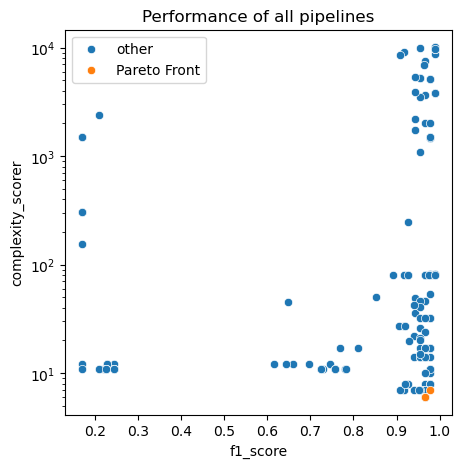

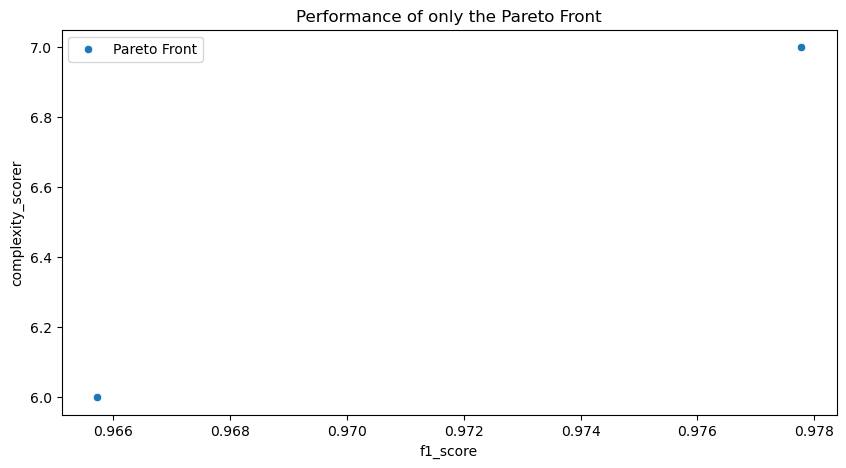

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
#replace nans in pareto front with 0

df = tpot.evaluated_individuals
metric = 'f1_score'

fig, ax = plt.subplots(figsize=(5,5))
sns.scatterplot(df[df['Pareto_Front']!=1], x=metric, y='complexity_scorer', label='other', ax=ax)
sns.scatterplot(df[df['Pareto_Front']==1], x=metric, y='complexity_scorer', label='Pareto Front', ax=ax)
ax.title.set_text('Performance of all pipelines')
#log scale y
ax.set_yscale('log')
plt.show()

#replace nans in pareto front with 0
fig, ax = plt.subplots(figsize=(10,5))
sns.scatterplot(df[df['Pareto_Front']==1], x=metric, y='complexity_scorer', label='Pareto Front', ax=ax)
ax.title.set_text('Performance of only the Pareto Front')
#log scale y
# ax.set_yscale('log')
plt.show()

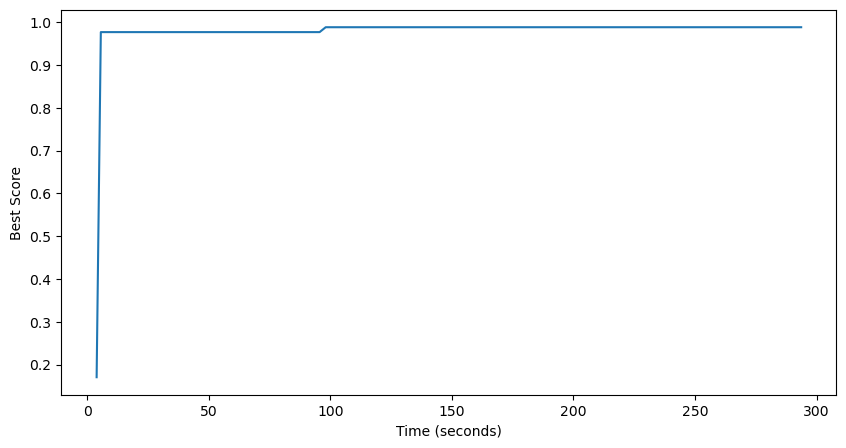

In [ ]:
import numpy as np

#get columns where roc_auc_score is not NaN
scores_and_times = df[df[metric].notna()][[metric, 'Completed Timestamp']].sort_values('Completed Timestamp', ascending=True).to_numpy()

#get best score at a given time
best_scores = np.maximum.accumulate(scores_and_times[:,0])
times = scores_and_times[:,1]
times = times - df['Submitted Timestamp'].min()

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(times, best_scores)
ax.set_xlabel('Time (seconds)')
ax.set_ylabel('Best Score')
plt.show()
